# IMPORTING RELEVANT LIBRARIES

In [37]:
#Settings
import warnings
import time


#Data Wrangling
import pandas as pd
import numpy as np

#Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


#Time Series Models
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Evaluation Metric
from sklearn.metrics import mean_absolute_error


warnings.simplefilter(action="ignore", category=FutureWarning)

**PREPARE DATA**

IMPORT

In [38]:
def wrangle(filename):
    # Load the data from the file into a DataFrame
    df = pd.read_csv(filename)
    
    # Drop unnecessary columns
    if "Unnamed: 7" in df.columns:
        df.drop(columns=["Unnamed: 7"], inplace=True)
    if "Unnamed: 8" in df.columns:
        df.drop(columns=["Unnamed: 8"], inplace=True)
    
    # Rename columns 
    if "Vol." in df.columns:
        df.rename(columns={"Vol.": "Volume(Million)"}, inplace=True)
    if "Change %" in df.columns:
        df.rename(columns={"Change %": "Change(%)"}, inplace=True)
    
    # Convert the 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Convert "[Price, Open, High, Low]" to float
    convert = ["Price", "Open", "High", "Low"]
    for c in convert:
        if c in df.columns:
            df[c] = df[c].str.replace(",", "", regex=False).astype(float, errors='ignore')
    
    # Convert "Change(%)" to float
    if "Change(%)" in df.columns:
        df["Change(%)"] = df["Change(%)"].str.replace("%", "", regex=False).astype(float, errors='ignore') 
    
    # Convert "Volume(Million)" to float with unit handling
    if "Volume(Million)" in df.columns:
        def convert_volume(value):
            if isinstance(value, str):
                value = value.strip()
                if value.endswith("M"):
                    return float(value[:-1]) * 1e6  
                elif value.endswith("K"):
                    return float(value[:-1]) * 1e3  
                else:
                    try:
                        return float(value) 
                    except ValueError:
                        return None 
            return value
        
        df["Volume(Million)"] = df["Volume(Million)"].apply(convert_volume).astype(float, errors='ignore')
    
    # Drop rows with missing values
    df.dropna(inplace=True)

     # Set 'Date' as the index
    df.set_index('Date', inplace=True)
    
    return df

In [39]:
df = wrangle("/kaggle/input/nigerian-stock-market-data/Nigerian_stock_market.csv")

In [40]:
print(df.shape)
df.head()

(22885, 7)


,Price,Open,High,Low,Volume(Million),Change(%),Ticker
Date,,,,,,,
2024-07-17,1.10,1.09,1.10,1.08,9110000.0,0.92,AIICO
2024-07-16,1.09,1.15,1.15,1.08,15880000.0,0.93,AIICO
2024-07-15,1.08,1.08,1.12,1.08,18910000.0,0.00,AIICO
2024-07-12,1.08,1.12,1.10,1.07,14610000.0,-3.57,AIICO
2024-07-11,1.12,1.10,1.12,1.09,15630000.0,1.82,AIICO


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22885 entries, 2024-07-17 to 2015-01-05
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price            22885 non-null  float64
 1   Open             22885 non-null  float64
 2   High             22885 non-null  float64
 3   Low              22885 non-null  float64
 4   Volume(Million)  22885 non-null  float64
 5   Change(%)        22885 non-null  float64
 6   Ticker           22885 non-null  object 
dtypes: float64(6), object(1)
memory usage: 1.4+ MB


In [42]:
print(df.isnull().sum())

Price              0
Open               0
High               0
Low                0
Volume(Million)    0
Change(%)          0
Ticker             0
dtype: int64


In [43]:
df.describe()

,Price,Open,High,Low,Volume(Million),Change(%)
count,22885.000000,22885.000000,22885.000000,22885.000000,2.288500e+04,22885.000000
mean,3457.823462,3455.024759,3453.725213,3425.019127,3.088929e+07,0.045801
std,12665.299829,12652.402535,12708.012644,12613.938986,9.772104e+07,2.625691
min,0.190000,0.000000,0.000000,0.000000,3.000000e+01,-53.060000
25%,15.000000,15.000000,11.500000,11.050000,1.525900e+05,-0.360000
50%,37.790000,37.720000,34.350000,33.500000,8.862700e+05,0.000000
75%,172.430000,172.430000,165.000000,164.000000,9.580000e+06,0.390000
max,105722.780000,105722.780000,106087.840000,104856.600000,9.980800e+08,35.000000


In [44]:
df["Ticker"].value_counts()

Ticker
AIICO            2360
ZENITHB          2360
NB               2360
NESTLE           2359
GUINNES          2359
UBA              2359
UNILEVE          2358
DANGCEM          2352
JBERGER          2287
NSE All Share    1731
Name: count, dtype: int64

Visualization Showing various Stock Price over time

# EXPLORE

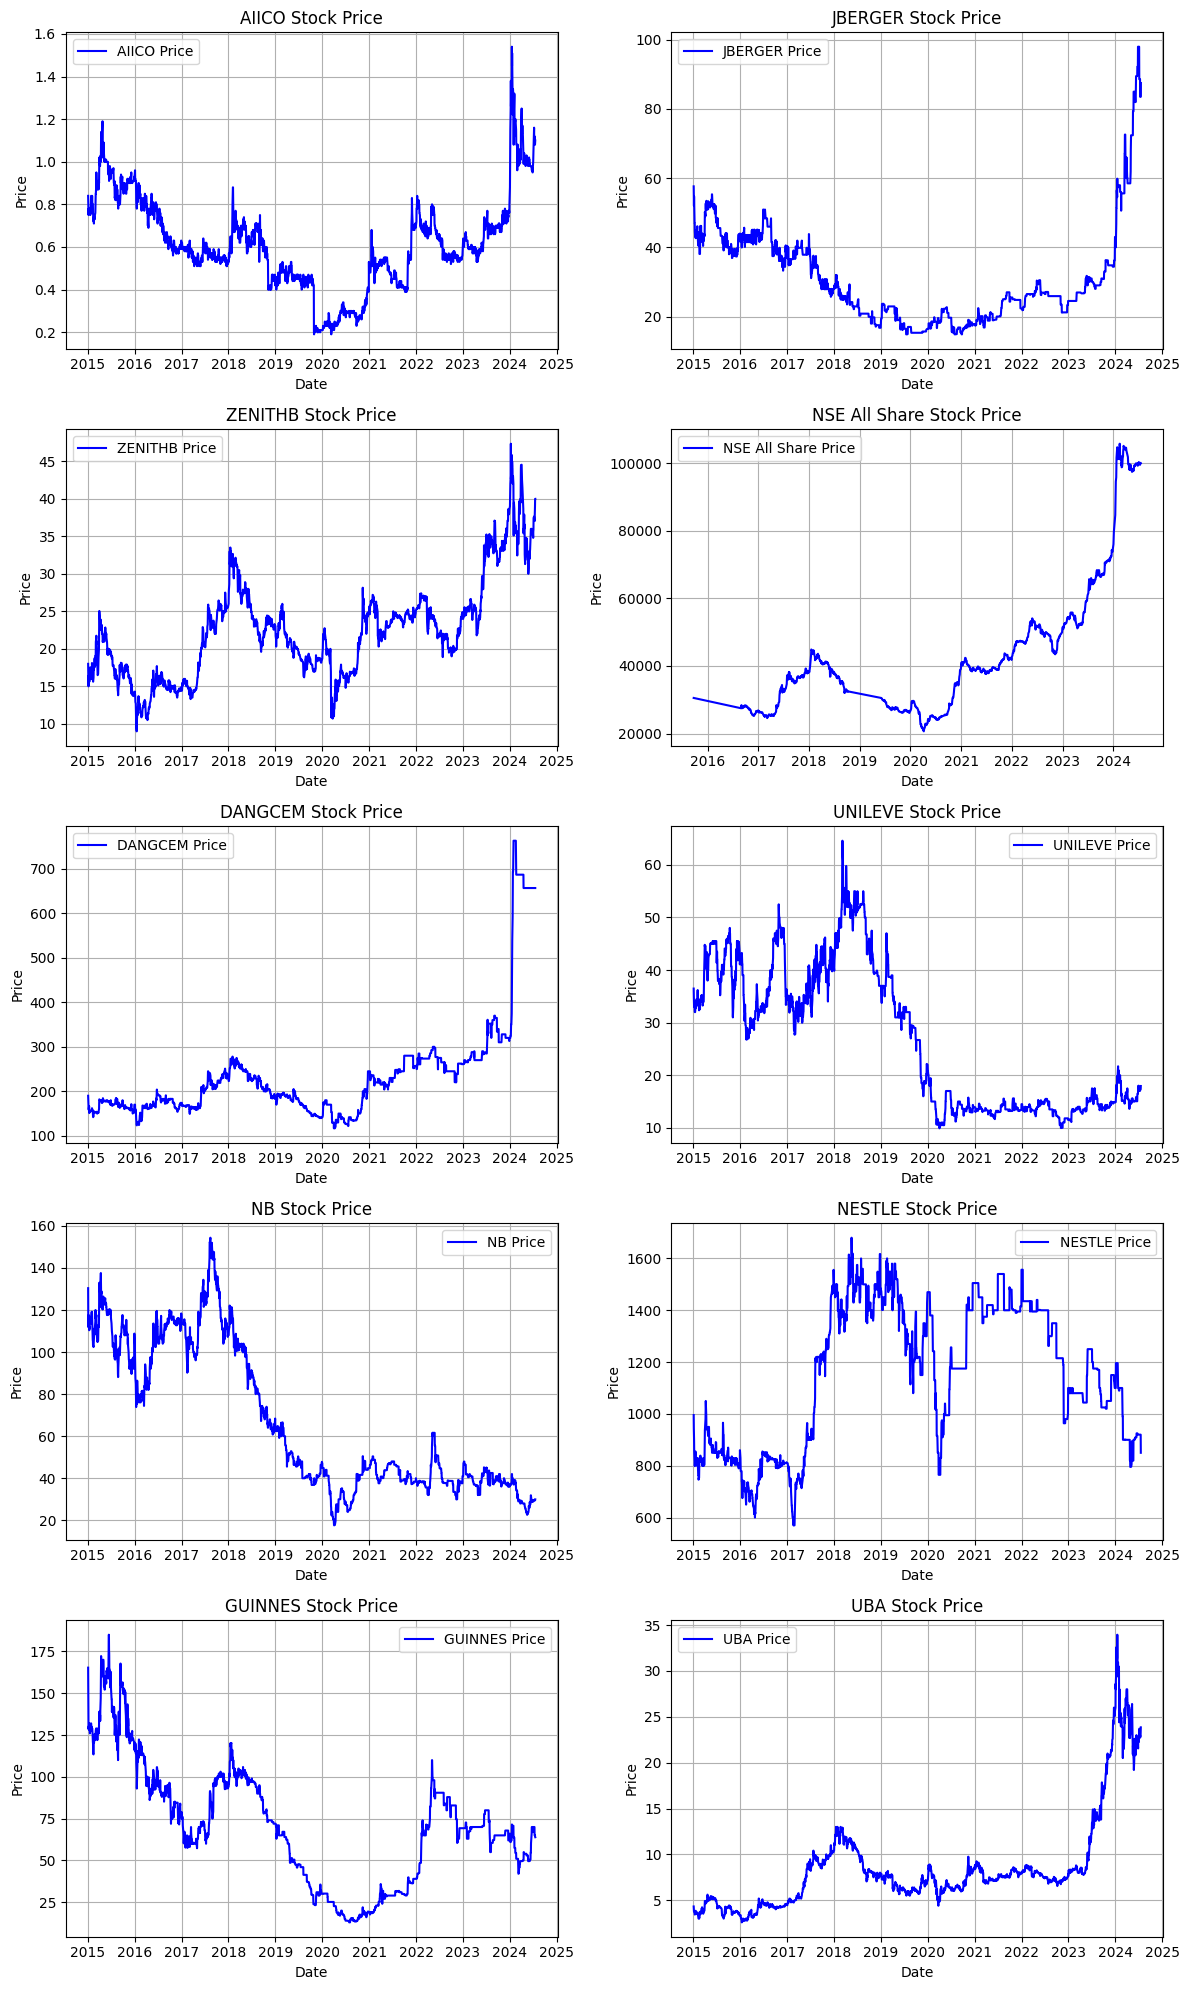

In [45]:

# Create a figure with 5 rows and 2 columns of subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 20))  # Adjust figsize for better visibility

# Get the unique tickers
tickers = df['Ticker'].unique()

# Ensure the number of tickers matches the number of subplots (up to 10)
num_plots = len(tickers)
if num_plots > 10:
    print("Warning: More than 10 tickers found. Only the first 10 will be plotted.")
    tickers = tickers[:10]

# Loop through each ticker and plot its 'Price' data
for i, ticker in enumerate(tickers):
    row = i // 2  
    col = i % 2   
    
    # Filter the data for the current ticker
    ticker_data = df[df['Ticker'] == ticker]
    
    # Plot the 'Price' column on the corresponding subplot
    ax = axes[row, col]  
    ax.plot(ticker_data.index, ticker_data['Price'], label=f'{ticker} Price', color='blue')
    ax.set_title(f'{ticker} Stock Price')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.grid(True)
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


 Visualization of weekly Stock Price Trend

In [ ]:
# Visualization for weekly Stock Price Trend

# Select only numeric columns
numeric_columns = df.select_dtypes(include='number').columns

# Group by 'Ticker' and resample each group to weekly data (mean of numeric columns)
weekly_data = df.groupby('Ticker')[numeric_columns].resample('W').mean().reset_index()

# Get the unique tickers
tickers = df['Ticker'].unique()

# Ensure we handle up to 10 tickers (5 rows × 2 columns)
num_tickers = len(tickers)
if num_tickers > 10:
    print("Warning: More than 10 tickers found. Only the first 10 will be plotted.")
    tickers = tickers[:10]

# Create a figure with 5 rows and 2 columns of subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 20))  # Adjust figsize for better visibility
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Plot the weekly prices for each ticker
for i, ticker in enumerate(tickers):
    # Filter the weekly data for the current ticker
    ticker_weekly = weekly_data[weekly_data['Ticker'] == ticker]
    
    # Plot the 'Price' column on the corresponding subplot
    ax = axes[i]  # Access the subplot using the flattened index
    ax.plot(ticker_weekly['Date'], ticker_weekly['Price'], color='purple')
    ax.set_title(f'{ticker} Weekly Stock Price Trend', fontsize=12)
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Price', fontsize=10)
    ax.grid(True)


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

    
   

Visualization of Rolling Average with a Window of 100 days.

In [ ]:

# Select only numeric columns
numeric_columns = df.select_dtypes(include='number').columns

# Group by 'Ticker' and calculate rolling averages
rolling_data = (
    df.groupby('Ticker')[['Price']]
      .rolling(window=100, min_periods=1)
      .mean()
      .reset_index()  )

# Ensure 'Date' is correctly set as a column
rolling_data.rename(columns={'level_1': 'Date'}, inplace=True)  

# Get the unique tickers
tickers = df['Ticker'].unique()

# Create a figure with 5 rows and 2 columns of subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 20))
axes = axes.flatten()

# Plot the rolling averages for each ticker
for i, ticker in enumerate(tickers):
    # Filter the rolling data for the current ticker
    ticker_rolling = rolling_data[rolling_data['Ticker'] == ticker]
    
    # Plot the rolling average on the corresponding subplot
    ax = axes[i]
    ax.plot(ticker_rolling['Date'], ticker_rolling['Price'], label=f'{ticker} 100-Day Rolling Avg', color='purple')
    ax.set_title(f'{ticker} 100-Day Rolling Average', fontsize=12)
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Price', fontsize=10)
    ax.grid(True)
    ax.legend()

# Hide any unused subplots if there are fewer than 10 tickers
for j in range(len(tickers), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

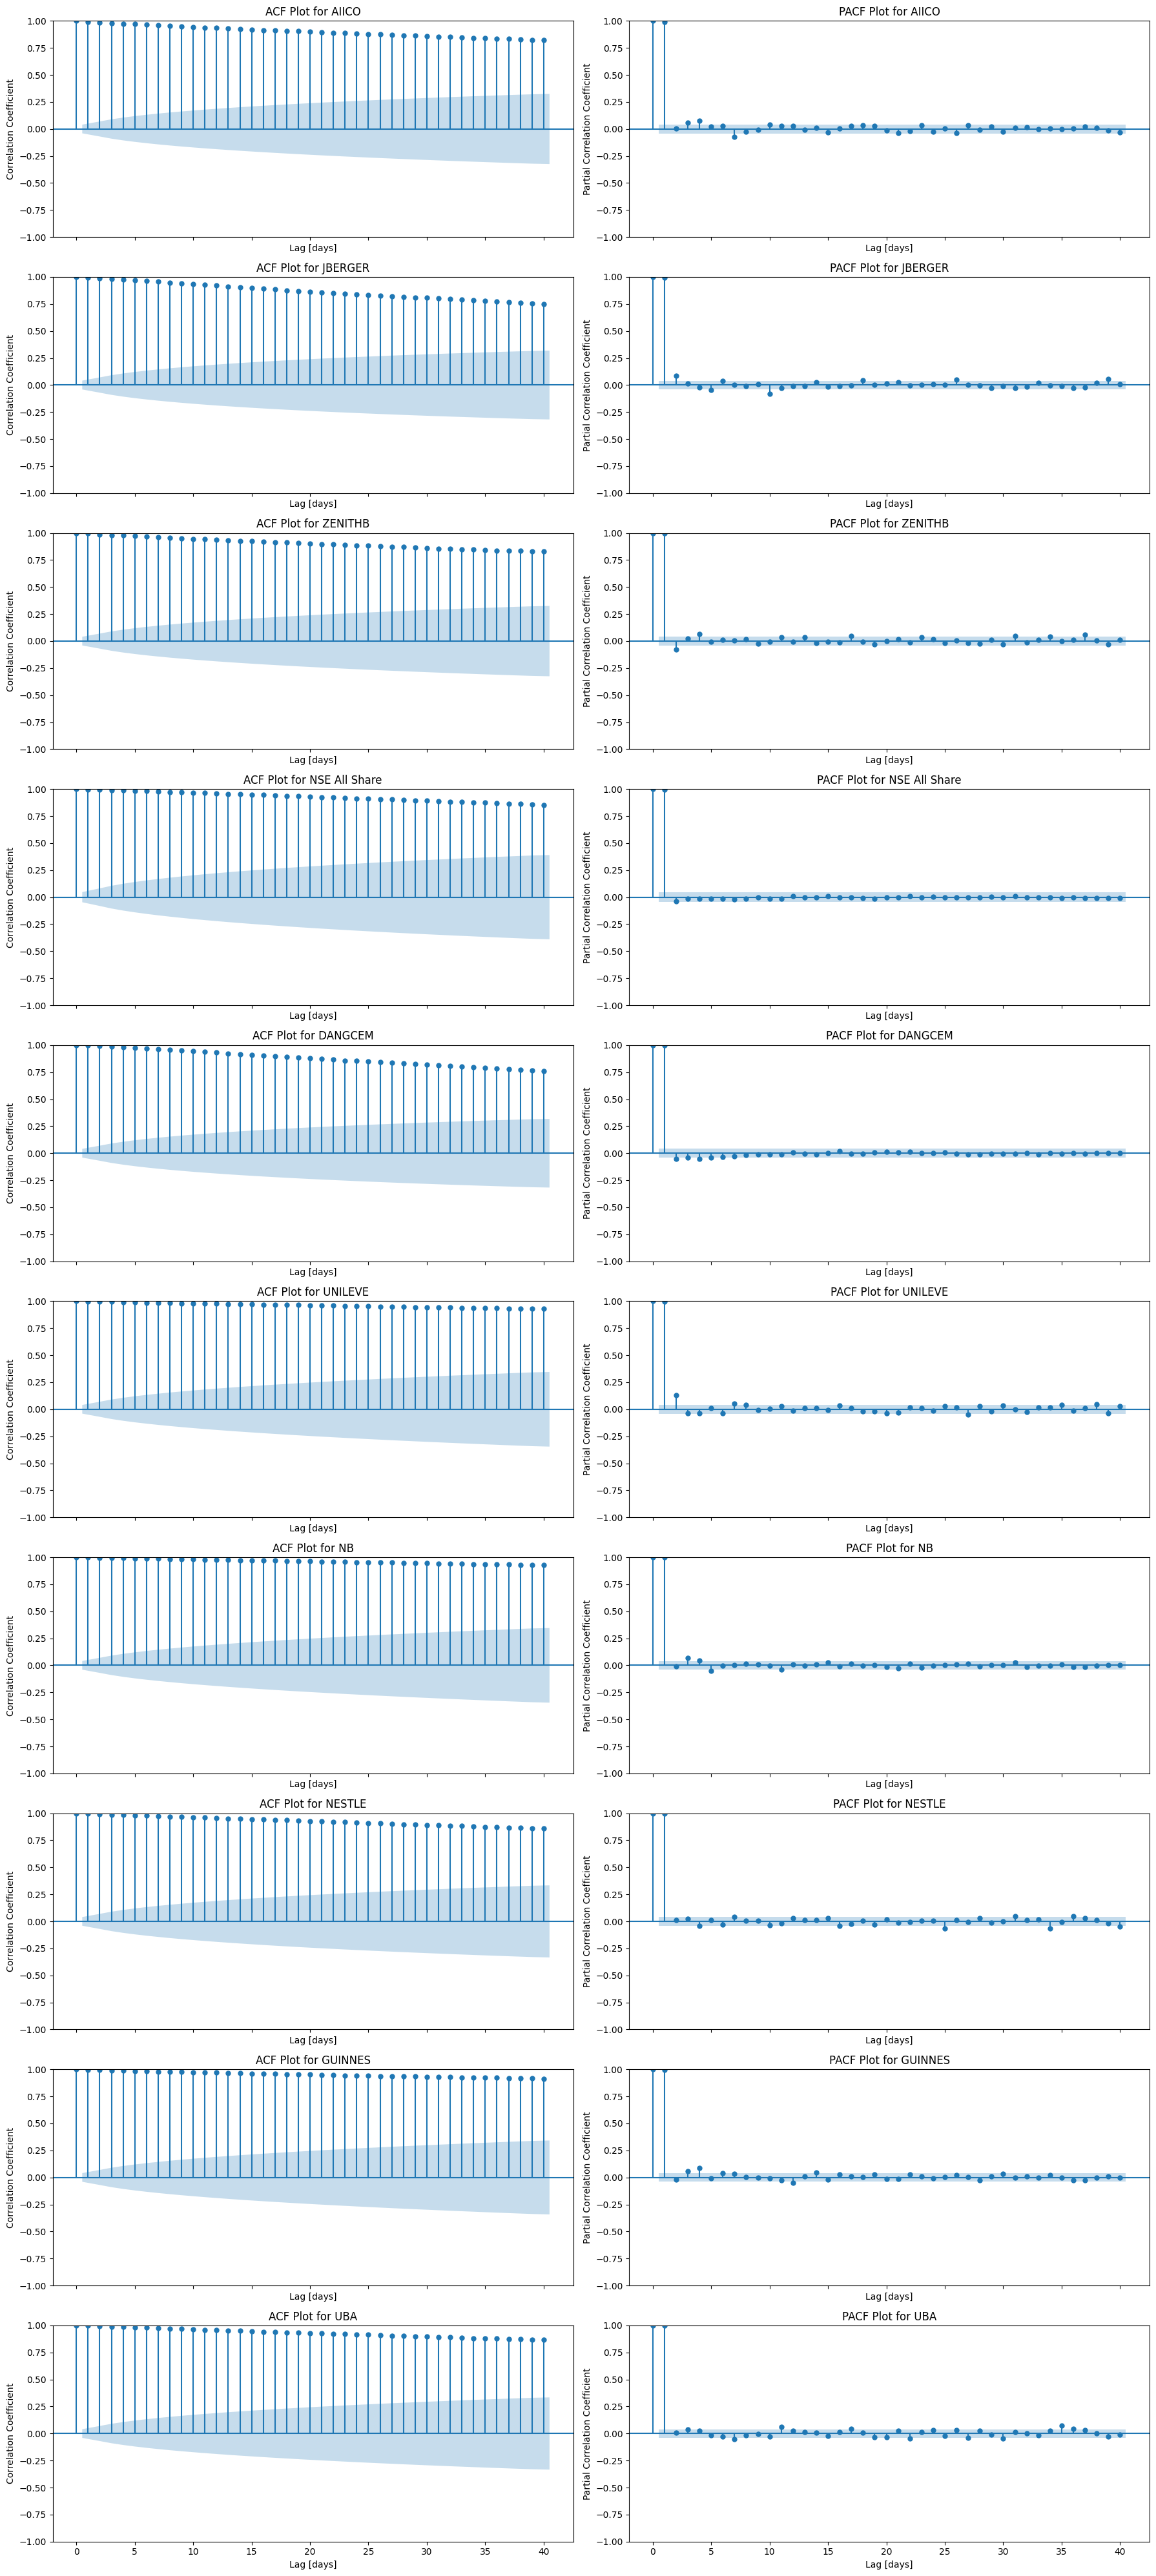

In [48]:
# Get unique tickers
tickers = df['Ticker'].unique()

# Create a figure with subplots for ACF and PACF
num_tickers = len(tickers)
fig, axes = plt.subplots(nrows=num_tickers, ncols=2, figsize=(18, 4 * num_tickers), sharex=True)

# Plot ACF and PACF for each ticker
for i, ticker in enumerate(tickers):
    ticker_data = df[df['Ticker'] == ticker]['Price']
    
    # Plot ACF
    ax_acf = axes[i][0] if num_tickers > 1 else axes[0]
    plot_acf(ticker_data.dropna(), ax=ax_acf, lags=40)
    ax_acf.set_title(f"ACF Plot for {ticker}")
    ax_acf.set_xlabel("Lag [days]")
    ax_acf.set_ylabel("Correlation Coefficient")
    
    # Plot PACF
    ax_pacf = axes[i][1] if num_tickers > 1 else axes[1]
    plot_pacf(ticker_data.dropna(), ax=ax_pacf, lags=40)
    ax_pacf.set_title(f"PACF Plot for {ticker}")
    ax_pacf.set_xlabel("Lag [days]")
    ax_pacf.set_ylabel("Partial Correlation Coefficient")

# Adjust layout and show plots
plt.tight_layout()
plt.show()

SPLIT

In [49]:
# Dictionary to store train-test splits for each company
train_test_splits = {}

# Group the data by 'Ticker'
for ticker, group in df.groupby('Ticker'):
    
    # Define X (features) and y (target)
    X = group[['Open', 'High', 'Low', 'Volume(Million)', 'Change(%)']]  # Features
    y = group['Price']  # Target variable
    
    # Calculate the cutoff point (80% for training, 20% for testing)
    cutoff = int(len(group) * 0.8)
    
    # Split into training and testing sets
    X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]  # Training data
    X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]    # Testing data
    
    # Store the splits for the current ticker
    train_test_splits[ticker] = {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test
    }



# BUILD MODEL

Baseline

In [50]:

# Dictionary to store baseline MAE for each company
baseline_mae = {}

# Loop through each ticker's train-test split
for ticker, splits in train_test_splits.items():
    
    # Extract training and testing data
    X_train = splits['X_train']
    y_train = splits['y_train']
    y_test = splits['y_test']
    
    # Baseline prediction: Use the last observed value from the training set
    last_price = y_train.iloc[-1]  
    baseline_predictions = [last_price] * len(y_test)  
    
    # Calculate MAE between baseline predictions and actual test prices
    mae = mean_absolute_error(y_test, baseline_predictions)
    
    # Store the MAE for the current ticker
    baseline_mae[ticker] = mae

# Print the baseline MAE for each company
for ticker, mae_value in baseline_mae.items():
    print(f"\nBaseline MAE for {ticker}: {mae_value:.4f}")
    


Baseline MAE for AIICO: 0.2397

Baseline MAE for DANGCEM: 12.7682

Baseline MAE for GUINNES: 35.0227

Baseline MAE for JBERGER: 8.2153

Baseline MAE for NB: 11.5067

Baseline MAE for NESTLE: 50.4361

Baseline MAE for NSE All Share: 11618.0020

Baseline MAE for UBA: 0.5912

Baseline MAE for UNILEVE: 9.6417

Baseline MAE for ZENITHB: 3.1663


LINEAR REGRESSION

In [51]:

# Dictionary to store evaluation results for each company
linear_regression_results = {}

# Loop through each ticker's train-test split
for ticker, splits in train_test_splits.items():
    
    # Extract training and testing data
    X_train = splits['X_train']
    y_train = splits['y_train']
    X_test = splits['X_test']
    y_test = splits['y_test']
    
    # Initialize and fit the Linear Regression model
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    
    # Make predictions on the training and testing sets
    y_train_pred = model_lr.predict(X_train)
    y_test_pred = model_lr.predict(X_test)
    
    # Calculate MAE for training and testing sets
    training_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Store the results for the current ticker
    linear_regression_results[ticker] = {
        'Training MAE': training_mae,
        'Test MAE': test_mae
    }

# Print the evaluation results for each company
for ticker, results in linear_regression_results.items():
    print(f"\nResults for {ticker}:")
    print(f"Training MAE: {results['Training MAE']:.4f}")
    print(f"Test MAE: {results['Test MAE']:.4f}")


Results for AIICO:
Training MAE: 0.0083
Test MAE: 0.0135

Results for DANGCEM:
Training MAE: 1.3881
Test MAE: 1.9291

Results for GUINNES:
Training MAE: 0.4808
Test MAE: 2.1380

Results for JBERGER:
Training MAE: 0.3458
Test MAE: 0.9142

Results for NB:
Training MAE: 0.3359
Test MAE: 0.7824

Results for NESTLE:
Training MAE: 5.2142
Test MAE: 12.8670

Results for NSE All Share:
Training MAE: 65.3288
Test MAE: 64.4065

Results for UBA:
Training MAE: 0.0737
Test MAE: 0.0733

Results for UNILEVE:
Training MAE: 0.2319
Test MAE: 0.6393

Results for ZENITHB:
Training MAE: 0.1210
Test MAE: 0.1609


AUTOREGRESSION

In [52]:

# Dictionary to store evaluation results for each company
autoreg_results = {}

# Loop through each ticker's train-test split
for ticker, splits in train_test_splits.items():
    
    # Extract training and testing data
    y_train = splits['y_train']  
    y_test = splits['y_test']    
    
   
    try:
        # Initialize and fit the AutoReg model with lags=7
        model = AutoReg(y_train, lags=7).fit()
        
        # Make predictions on the training set
        y_train_pred = model.fittedvalues
        
        # Forecast future values for the test set
        y_test_pred = model.forecast(steps=len(y_test))
        
        # Calculate MAE for training and testing sets
        training_mae = mean_absolute_error(y_train[7:], y_train_pred)  # Exclude first 7 points (not predicted)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        # Store the results for the current ticker
        autoreg_results[ticker] = {
            'Training MAE': training_mae,
            'Test MAE': test_mae
        }
    except Exception as e:
        print(f"Failed to fit AutoReg model for {ticker}: {e}")

# Print the evaluation results for each company
for ticker, results in autoreg_results.items():
    print(f"\nResults for {ticker}:")
    print(f"Training MAE: {results['Training MAE']:.4f}")
    print(f"Test MAE: {results['Test MAE']:.4f}")


Results for AIICO:
Training MAE: 0.0149
Test MAE: 0.2781

Results for DANGCEM:
Training MAE: 2.4346
Test MAE: 36.1809

Results for GUINNES:
Training MAE: 0.7366
Test MAE: 42.9672

Results for JBERGER:
Training MAE: 0.3615
Test MAE: 16.6961

Results for NB:
Training MAE: 0.7924
Test MAE: 12.9807

Results for NESTLE:
Training MAE: 10.2734
Test MAE: 255.2217

Results for NSE All Share:
Training MAE: 260.1686
Test MAE: 8662.9646

Results for UBA:
Training MAE: 0.1806
Test MAE: 1.8178

Results for UNILEVE:
Training MAE: 0.4520
Test MAE: 8.5666

Results for ZENITHB:
Training MAE: 0.3456
Test MAE: 2.6590


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  

ARIMA

In [53]:

# Dictionary to store evaluation results for each company
arima_results = {}

# Loop through each ticker's train-test split
for ticker, splits in train_test_splits.items():
    print(f"\nFitting ARIMA models for {ticker}...")
    
    # Extract training and testing data
    y_train = splits['y_train']  # Target variable for training
    y_test = splits['y_test']    # Target variable for testing
    
    # Ensure there are enough data points for the specified lags (e.g., p=24)
    if len(y_train) <= 24:  # Example: If p_max=24, ensure y_train has at least 25 data points
        print(f"Not enough data for {ticker} (only {len(y_train)} rows). Skipping...")
        continue
    
    try:
        # Define hyperparameter ranges
        p_params = range(0, 25, 8)  # p values from 0 to 24, step=8
        q_params = range(0, 3, 1)   # q values from 0 to 2, step=1
        
        # Dictionary to store MAE results for this ticker
        arima_results[ticker] = {}
        
        # Outer loop: Iterate through possible values for `p`
        for p in p_params:
            # Inner loop: Iterate through possible values for `q`
            for q in q_params:
                order = (p, 0, q)  # ARIMA(p, d=0, q)
                
                # Train ARIMA model
                model = ARIMA(y_train, order=order).fit()
                
                # Generate in-sample (training) predictions
                y_train_pred = model.fittedvalues
                
                # Calculate training MAE (exclude first `p` points)
                training_mae = mean_absolute_error(y_train[p:], y_train_pred)
                
                # Forecast future values for the test set
                y_test_pred = model.forecast(steps=len(y_test))
                
                # Calculate test MAE
                test_mae = mean_absolute_error(y_test, y_test_pred)
                
                # Store the results for this hyperparameter combination
                arima_results[ticker][order] = {
                    'Training MAE': training_mae,
                    'Test MAE': test_mae
                }

    except Exception as e:
        print(f"Failed to fit ARIMA models for {ticker}: {e}")

# Print the best training and test MAE for each company
for ticker, results in arima_results.items():
    print(f"\nResults for {ticker}:")
    
    # Find the order with the lowest test MAE
    best_order = min(results, key=lambda x: results[x]['Test MAE'])
    best_training_mae = results[best_order]['Training MAE']
    best_test_mae = results[best_order]['Test MAE']
    
    print(f"Best ARIMA Order: {best_order}")
    print(f"  Training MAE: {best_training_mae:.4f}")
    print(f"  Test MAE: {best_test_mae:.4f}")


Fitting ARIMA models for AIICO...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

Failed to fit ARIMA models for AIICO: Found input variables with inconsistent numbers of samples: [1880, 1888]

Fitting ARIMA models for DANGCEM...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

Failed to fit ARIMA models for DANGCEM: Found input variables with inconsistent numbers of samples: [1873, 1881]

Fitting ARIMA models for GUINNES...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

Failed to fit ARIMA models for GUINNES: Found input variables with inconsistent numbers of samples: [1879, 1887]

Fitting ARIMA models for JBERGER...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

Failed to fit ARIMA models for JBERGER: Found input variables with inconsistent numbers of samples: [1821, 1829]

Fitting ARIMA models for NB...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

Failed to fit ARIMA models for NB: Found input variables with inconsistent numbers of samples: [1880, 1888]

Fitting ARIMA models for NESTLE...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

Failed to fit ARIMA models for NESTLE: Found input variables with inconsistent numbers of samples: [1879, 1887]

Fitting ARIMA models for NSE All Share...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

Failed to fit ARIMA models for NSE All Share: Found input variables with inconsistent numbers of samples: [1376, 1384]

Fitting ARIMA models for UBA...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

Failed to fit ARIMA models for UBA: Found input variables with inconsistent numbers of samples: [1879, 1887]

Fitting ARIMA models for UNILEVE...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

Failed to fit ARIMA models for UNILEVE: Found input variables with inconsistent numbers of samples: [1878, 1886]

Fitting ARIMA models for ZENITHB...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

Failed to fit ARIMA models for ZENITHB: Found input variables with inconsistent numbers of samples: [1880, 1888]

Results for AIICO:
Best ARIMA Order: (0, 0, 2)
  Training MAE: 0.0523
  Test MAE: 0.2542

Results for DANGCEM:
Best ARIMA Order: (0, 0, 2)
  Training MAE: 23.3440
  Test MAE: 83.6980

Results for GUINNES:
Best ARIMA Order: (0, 0, 2)
  Training MAE: 6.9298
  Test MAE: 60.1559

Results for JBERGER:
Best ARIMA Order: (0, 0, 2)
  Training MAE: 2.7179
  Test MAE: 15.8282

Results for NB:
Best ARIMA Order: (0, 0, 2)
  Training MAE: 7.5628
  Test MAE: 47.4699

Results for NESTLE:
Best ARIMA Order: (0, 0, 2)
  Training MAE: 65.7847
  Test MAE: 430.9541

Results for NSE All Share:
Best ARIMA Order: (0, 0, 2)
  Training MAE: 6222.6470
  Test MAE: 15345.5718

Results for UBA:
Best ARIMA Order: (0, 0, 2)
  Training MAE: 1.0875
  Test MAE: 5.6187

Results for UNILEVE:
Best ARIMA Order: (0, 0, 2)
  Training MAE: 3.6586
  Test MAE: 14.3975

Results for ZENITHB:
Best ARIMA Order: (0, 0, 2)

Long Short-term Memory - LSTM (Deep Learning)

In [58]:

# Dictionary to store evaluation results for each company
lstm_results = {}

# Function to reshape data for LSTM
def create_lstm_dataset(data, look_back=7):
    """
    Reshapes the data into 3D format required by LSTM: (samples, time_steps, features).
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

# Loop through each ticker's train-test split
for ticker, splits in train_test_splits.items():
    print(f"\nTraining LSTM model for {ticker}...")
    
    # Extract training and testing data
    y_train = splits['y_train'].values  # Target variable for training (as NumPy array)
    y_test = splits['y_test'].values    # Target variable for testing (as NumPy array)
    
    # Ensure there are enough data points for the specified look-back period
    look_back = 7  # Number of previous time steps to use as input
    if len(y_train) <= look_back:
        print(f"Not enough data for {ticker} (only {len(y_train)} rows). Skipping...")
        continue
    
    try:
        # Create LSTM datasets for training and testing
        x_train, y_train_reshaped = create_lstm_dataset(y_train, look_back=look_back)
        x_test, y_test_reshaped = create_lstm_dataset(y_test, look_back=look_back)
        
        # Skip if reshaped datasets are too small
        if len(x_train) == 0 or len(x_test) == 0:
            print(f"Reshaped dataset for {ticker} is too small. Skipping...")
            continue
        
        # Build the LSTM model
        model_lstm = Sequential()
        model_lstm.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
        model_lstm.add(LSTM(64, return_sequences=False))
        model_lstm.add(Dense(25))
        model_lstm.add(Dense(1))  # Output layer
        
        # Compile the model with MAE loss
        model_lstm.compile(optimizer='adam', loss='mean_absolute_error')
        
        # Reshape input data to include a single feature dimension
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
        
        # Train the model
        model_lstm.fit(x_train, y_train_reshaped, batch_size=32, epochs=20, verbose=0)
        
        # Make predictions on training and test sets
        y_train_pred = model_lstm.predict(x_train).flatten()
        y_test_pred = model_lstm.predict(x_test).flatten()
        
        # Calculate training and test MAE
        training_mae = mean_absolute_error(y_train_reshaped, y_train_pred)
        test_mae = mean_absolute_error(y_test_reshaped, y_test_pred)
        
        # Store the results for the current ticker
        lstm_results[ticker] = {
            'Training MAE': training_mae,
            'Test MAE': test_mae
        }
    
    except Exception as e:
        print(f"Failed to train LSTM model for {ticker}: {e}")

# Print the evaluation results for each company
for ticker, results in lstm_results.items():
    print(f"\nResults for {ticker}:")
    print(f"  Training MAE: {results['Training MAE']:.4f}")
    print(f"  Test MAE: {results['Test MAE']:.4f}")


Training LSTM model for AIICO...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Training LSTM model for DANGCEM...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Training LSTM model for GUINNES...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Training LSTM model for JBERGER...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Training LSTM model for NB...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Training LSTM model for NESTLE...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Training LSTM model for NSE All Share...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Training LSTM model for UBA...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Training LSTM model for UNILEVE...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Training LSTM model for ZENITHB...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Results for AIICO:
  Training MAE: 0.0205
  Test MAE: 0.0202

Results for DANGCEM:
  Training MAE: 12.4212
  Test MAE: 2.8795

Results for GUINNES:
  Training MAE: 0.8156
  Test MAE: 13.8990

Results for JBERGER:
  Training MAE: 0.7809
  Test MAE: 1.2183

Results for NB:
  Training MAE: 0.9754
  Test MAE: 2.0706

Results for NESTLE:
  Training MAE: 194.0175
  Test MAE: 470.6936

Results for NSE All Share:
  Training MAE: 43004.0092
  Test MAE: 27655.2555

Results for UBA:
  Training MAE: 0.2505
  Test MAE: 0.2605

Results for UNILEVE:
  Training MAE: 0.5624
  Test MAE: 0.9484

Results for ZENITHB:
  Training MAE: 0.4373
  Test MAE: 0.4495


**CONCLUSION: After Training several Time Series Models, The best performing model was the LSTM model which employs deep learning. So i saved it and decided to use it in deployment.**

In [59]:
final_model = f"{ticker}_lstm_model.keras"
model_lstm.save(final_model)